<h1><center>Gradient Based Optimization</center></h1>

<br>
<br>
<center><font size="3">This notebook is a part of teaching material for CS-EJ3311 - Deep Learning with Python</font></center>
<center><font size="3">24.10.-11.12.2022</font></center>
<center><font size="3">Aalto University & FiTech.io</font></center>

This notebook demonstrates a simple but powerful method to find an optimal choice for the parameters (weights and biases) of an artificial neural network (ANN). The idea is to tune (adjust) the parameters according to the gradient of the average loss incurred by the ANN on a training set. This average loss is also known as the **training loss** (or training error) and defines an **objective or cost function** $f(\mathbf{w})$ that we want to minimize.  

Here we discuss a simple iterative algorithm which is called **gradient descent** (GD). GD minimizes the training loss by incrementally improving the current guess for the optimal parameters by moving a bit into the direction of the negative gradient. We will also discuss a simple variant of GD known as **stochastic gradient descent** (SGD). SGD is one of the most widely used optimization methods within deep learning.

## Learning Goals

- understand how gradients of the loss function can be used to learn the parameters of an ANN

- understand the basic idea behind stochastic gradient descent (SGD)

- understand SGD components "batch", "batch size", "learning rate" and "epoch"

- be aware of some advanced variants of SGD such as ADAM or RMSprop

## Additional Reading

-  Loss function chapter 1.1.5 & Gradient-based optimization chapter 2.4 of the book "Deep Learning with Python" by F. Chollet. 
-  Gradient descent Chapter 4 & 11 of "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron. 

Advanced reading:

- Chapter 2.3 & 5 of "Machine Learning: Basic Principles" https://arxiv.org/pdf/1805.05052.pdf
- Optimization Chapter of Deep Learning Book https://www.deeplearningbook.org/contents/optimization.html

## Video materials

Beginner-friendly videos:
- 3Blue1Brown, https://www.youtube.com/watch?v=IHZwWFHWa-w
- StatQuest, https://www.youtube.com/watch?v=sDv4f4s2SB8

Videos from Andrew Ng's courses  with a brief intro to:
- GD, https://www.youtube.com/watch?v=F6GSRDoB-Cg 
- Adam, https://youtu.be/JXQT_vxqwIs 
- RMSprop, https://youtu.be/_e-LFe_igno

In [1]:
from utils import load_styles

# This MUST be the last line of this cell
load_styles()

Deep learning aims at finding a good choice for the weights (and biases) of an **artificial neural network (ANN)**. We need to define a loss function to measure how "good" a particular choice for these parameters is. For a given pair of predicted label value $\hat{y}$ and true label value $y$, the loss function $L(y,\hat{y})$ provides a measure for the error, or "loss", incurred in predicting the true label $y$ by $\hat{y}$. We emphasize that the precise definition of the loss function is a design choice. In principle, the deep learning engineer is free to choose an arbitrary loss function used to guide the training of an ANN.  

Some particular choices for the loss function have been proven to be useful in many applications. If the label values are numeric (like a temperature or a weight), then the **squared error** loss $ L(y,\hat{y})=(y-\hat{y})^2$ is a good choice for the loss function. \
If the label values are categories (like "cat" and "dog"), we might use  the logistic loss $L(y,\hat{y}) = -y\ln\big(\hat{p}(y=1)\big)-(1-y)\ln\big(\hat{p}(y=0)\big)$ where $\hat{p}$ is an estimate for the probability that label value is $y=1$ or $y=0$.

To measure the quality of particular choice for the parameters of an ANN, we typically use a set of labeled data points 

$$\big(\mathbf{x}^{(1)},y^{(1)}\big),\ldots,\big(\mathbf{x}^{(m)},y^{(m)}\big).$$

We first compute the resulting predictions $\hat{y}^{(i)}$ obtained when feeding the feature vectors $\mathbf{x}^{(i)}$ into the ANN. Based on the predictions, we calculate the average loss (or training loss)

$$ (1/m) \big( L(y^{(1)},\hat{y}^{(1)})+L(y^{(2)},\hat{y}^{(2)})+\ldots+L(y^{(m)},\hat{y}^{(m)}) \big).$$

Note that the training loss depends on the parameters $\mathbf{w}$ of the ANN via the predictions $\hat{y}^{(i)}$. Indeed, the predictions $\hat{y}^{(i)}=h^{(\mathbf{w})}\big(\mathbf{x}^{(i)}\big)$ are obtained by applying the ANN with parameters $\mathbf{w}$ to the input feature vector $\mathbf{x}^{(i)}$. By evaluating the training loss for different choices for the weights, we obtain a **cost or objective function** $f(\mathbf{w})$. The objective function $f(\mathbf{w})$ is the average loss incurred by an ANN with parameters $\mathbf{w}$. It seems natural to learn parameters of an ANN that minimize the training loss, i.e., that solve

$$ \min_{\mathbf{w} \in \mathbb{R}^{d}} f(\mathbf{w})$$

<div class="info">
    <div  class="info-title"><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</div><br>
    <div class="wrap-up-content">
        Here we use following format:
        <br>
        <ul>
          <li>non-bold font and lower case for scalar variables ( true label $y$, predicted label $\hat{y}$ )</li>
          <li>bold font and lower case for vectors ( features of a datapoint stacked into a vector $\mathbf{x}$, ANN parameters stacked into a vector $\mathbf{w}$ )</li>
          <li>bold font and upper case for matrices ( feature matrix $\mathbf{X}$ )</li>
        </ul>
    </div>
</div>

## Mean Squared Error 

Maybe the most widely used loss function for applications involving numeric label values $y \in \mathbb{R}$ is the squared error loss 

$$L(y,\hat{y}) = (\underbrace{y- \hat{y}}_{\mbox{prediction error}})^{2}.$$

We assess the quality of a predictor $\hat{y} = h^{(\mathbf{w})}(\mathbf{x})$ by the average loss incurred over a set of labeled data points (the **training set**). For the squared error, average loss is referred to as the **mean squared error (MSE)** 

$$ f(\mathbf{w}) = (1/m) \big( \big( y^{(1)}-\hat{y}^{(1)}\big)^{2}+\big( y^{(2)}-\hat{y}^{(2)}\big)^{2}+\ldots+\big( y^{(m)}-\hat{y}^{(m)}\big)^{2} \big). $$
Note that the MSE on the right hands side depends on the weight vector $\mathbf{w}$ via the predictions $\hat{y}^{(i)}$ obtained by applying the predictor map $h^{(\mathbf{w})}\big(\mathbf{x}^{(i)}\big)$. 

The shape of the loss $f(\mathbf{w})$, viewed as a function of the weights $\mathbf{w}$, depends on two components. First, it depends on how the predictor map depends on the weights (the structure of the ANN in deep learning context). Second, it depends on the choice of the loss function $L(y,\hat{y})$ used to measure the loss incurred by predicting the true label value $y$ with the prediction $\hat{y}$. 

The combination of linear predictor function and squared error loss $L(y,\hat{y})=(y-\hat{y})^{2}$ is a very popular as they result in a [convex](https://en.wikipedia.org/wiki/Convex_function) and [differentiable](https://en.wikipedia.org/wiki/Differentiable_function) loss function $f(\mathbf{w})$. A convex function has the attractive property that any local minimum is always also a [global minimum](https://en.wikipedia.org/wiki/Maxima_and_minima#/media/File:Extrema_example_original.svg). If a convex function is also differentiable, it can be minimized by a simple but powerful algorithm which is known as **gradient descent**. 

<img src="../../../coursedata/SGD/MSELinPred.jpeg" width=400>


Deep learning methods use predictor maps represented by ANN with tunable weights. In this case, the predictor depends non-linearly on the weights. As a result, we obtain (highly) non-convex loss landscapes. Below, examples of loss function landscapes of more complicated models (neural networks) illustrate that finding a minimum of these loss functions is not a trivial task.

<img src="../../../coursedata/SGD/NNloss.png" width=500/>


<center><a href="https://www.cs.umd.edu/~tomg/projects/landscapes/">image source</a></center>
<center><a href="https://arxiv.org/abs/1712.09913/">original paper</a></center>

Here you can find more examples of visualizations for loss functions obtained from representing a predictor map using ANN:

[3D visualization of NN loss functions](http://www.telesens.co/loss-landscape-viz/viewer.html) \
[3D animation of NN loss functions](https://www.youtube.com/watch?time_continue=32&v=aq3oA6jSGro&feature=emb_logo)

# Gradient Descent 

We will now introduce a simple algorithm that allows to find (a good approximation to) the optimal parameter vector $\mathbf{w}_{\rm opt}$ for a predictor map $h^{(\mathbf{w})}(\mathbf{x})$. The optimum weight vector should result in the smallest possible loss  

\begin{align} 
f(\mathbf{w}_{\rm opt}) = \min_{\mathbf{w} \in \mathbb{R}^{d}} f(\mathbf{w}) \mbox{ with } f(\mathbf{w})& = (1/m) \sum_{i=1}^{m} \big(y^{(i)} - \hat{y}^{(i)} \big)^{2} \nonumber \\ 
& =(1/m) \sum_{i=1}^{m} \big(y^{(i)} - h^{(\mathbf{w})}\big(\mathbf{x}^{(i)}\big) \big)^{2}. \end{align}

**Gradient descent (GD)** constructs a sequence of parameter vectors $\mathbf{w}^{(0)},\mathbf{w}^{(1)},\ldots$ such that the loss values $f\big(\mathbf{w}^{(0)}\big),f\big(\mathbf{w}^{(1)}\big),\ldots$ tends toward the minimum loss. GD is an iterative algorithm that gradually improves the current guess (approximation) $\mathbf{w}^{(k)}$ for the optimum weight vector.  

There are many different strategies for choosing the first (or initial) guess $\mathbf{w}^{(0)}$. One simple approach is to choose the initial weights randomly. Given the current weight vector $\mathbf{w}^{(k)}$, how does GD know in which "direction" to go to find a better parameter vector $\mathbf{w}^{(k+1)}$? Mathematics, or [calcululs](https://en.wikipedia.org/wiki/Differential_calculus) to be specific, tells us that this direction is precisely the opposite of the gradient $\nabla f(\mathbf{w})$. More precisely, for a small step size, the steepest descent is towards the opposite direction of the [gradient](https://en.wikipedia.org/wiki/Derivative). We can think of [GD](https://en.wikipedia.org/wiki/Gradient_descent) as imitating a hiker who takes a sequence of (small) steps downhill.

<img src="../../../coursedata/SGD/GradientHiker.jpeg" width=500/>

Given the downhill direction $- \nabla f\big(\mathbf{w}^{(k)}\big)$ at the current estimate $\mathbf{w}^{(k)}$, we take a step 

$$\mbox{(Gradient Step)} \quad \underbrace{\mathbf{w}^{(k+1)}}_{\mbox{new guess}} = \underbrace{\mathbf{w}^{(k)}}_{\mbox{current guess}} - \underbrace{\alpha}_{\mbox{step size}} \nabla f\big(\mathbf{w}^{(k)}\big).$$ 

Here, we used a tuning parameter $\alpha>0$ which adjusts the step size for the steep downhill. We will refer to this parameter as **learning rate**. This name is due to the fact that choosing a larger value for $\alpha$ tends to speed up the progress of GD to reach the optimum weight vector. Thus, increasing the value of $\alpha$ tends to speed up the learning of a good weight vector for a predictor map $h^{(\mathbf{w})}$. 

The GD algorithm requires the specification of a suitable learning rate  $\alpha$ and initial guess $\mathbf{w}^{(0)}$ and then repeating the gradient step for a sufficient number of iterations. One possible stopping criterion is to use a fixed number of iterations which might be dictated by constraints on processing duration we grant for GD (computing time costs money, [see here](https://aws.amazon.com/emr/pricing/)). 

Another option is to monitor the loss function and stop if consecutive iterates do not result in any significant decrease. Similarly, we could monitor the validation loss which is obtained by applying the predictor map using the current GD iterate $\mathbf{w}^{(k)}$ to validation data which is different from the training data used to define the training loss. 

A key challenge in the use of GD is to find a good choice for the learning rate $\alpha$. If the learning rate is too small (left plot below), the GD steps make too little progress and thus require an excessive number of iterations to get close to the optimum weight vector. Conversely, if the learning rate is too high (right plot below), it is possible that GD iterates $\mathbf{w}^{(k)}$ will "overshoot" the minimum and climb up the loss function on the other side of the minimum (GD diverges). 

<img src="../../../coursedata/SGD/lrate.png" width=800/>

The figure below shows how GD adapts the parameter vector $\mathbf{w}$ of a linear predictor $h^{(\mathbf{w})}(\mathbf{x})= \mathbf{w}^{T} \mathbf{x}$ to better fit the labeled data points (left) resulting in a smaller MSE (right). Note that after around $200$ iterations, gradient descent found weight vectors resulting in an almost minimum MSE. The additional iterations (beyond $200$) are (in some sense) a waste of computation as they do not decrease the MSE significantly. 

<img src="../../../coursedata/SGD/plainGD.gif" width="750" align="center">

To develop some intuition for the functioning of GD, let us work out the gradient update for the special case of linear predictor maps $h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$. Here, we can find a closed-form expression for the gradient: 

\begin{align} 
\nabla f\big( \mathbf{w}^{(k)} \big)= - (2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big) \big). \end{align}

The gradient update of GD then becomes, in turn, 

\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + {\alpha}\,(2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big)\nonumber \\ 
 & = \mathbf{w}^{(k)} + {\alpha}\,(2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big( y^{(i)} - \hat{y}^{(i)} \big) 
. \end{align}

Note that the gradient update involves the computation of the predictions $\hat{y}^{(i)} = \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)}$. 

After the forward pass, the weight vector $\mathbf{w}^{(k)}$ is updated by a weighted combination of the feature vectors $\mathbf{x}^{(i)}$. The weight for the $i$th feature vector $\mathbf{x}^{(i)}$ is given by the prediction error $ \big( y^{(i)}$ - $\hat{y}^{(i)} \big)$ incurred by the current parameter vector for that data point. Thus, the gradient update puts more emphasis (larger weight) on those data points $\big(\mathbf{x}^{(i)},y^{(i)}\big)$ which are not well predicted using the current weight vector $\mathbf{w}^{(k)}$. 



Many machine learning and deep learning Python libraries, such as `sklearn` and `keras`, provide ready-to-use gradient-based optimization algorithms. However, it is instructive to implement our own simplified gradient descent algorithm for learning purposes. In this simple case, we have 100 data points (samples) that are described by only one feature `x`, and a label `y`. \
We need to find the optimal linear predictor `y_pred = weight * x`.

In [2]:
# import Python libraries
import numpy as np                                 # library for numerical arrays (vectors, matrices, tensors)
import matplotlib.pyplot as plt                    # library providing tools for plotting data 
from sklearn import preprocessing                  # function for pre-processing input data
from sklearn.linear_model import LinearRegression  # sklearn class for fitting linear predictor 
from sklearn.datasets import make_regression       # function to generate a random regression problem

<a id='St1'></a>
<div class=" alert alert-warning">
    <h3><b>STUDENT TASK 2.1.</b> GRADIENT DESCENT. </h3>
        
Your task is to implement the gradient descent algorithm for a dataset of size $m$, where $i$th datapoint is characterized by only one feature ${x}^{(i)}$. Feature values for all $m$ data points are stored in a numpy array `x` of shape (m,1). Labels of datapoints are stored in numpy array `y` of shape (m,1).

Implement GD algorithm in two steps:
    
- implement gradient "step" or one iteration of GD in Python function `gradient_step_onefeature()`
- define Python function `GD()`, which uses `gradient_step_onefeature()` and iterates the gradient step epochs times.
  
**Implementation note.**

You can use for-loop to compute training loss and gradient for each datapoint, but we advise to use vectorized implementation where you use NumPy arrays (vectors) `x` and `y` and dot product operation for computing predictions and gradient.    
    
</div>

<details>
    <summary>
        <span class="summary-title">Hints</span>
    </summary>
    <div class="summary-content">

To implement the `gradient_step_onefeature()` function you will need to perform following steps:
    
1. Compute predictions for all data points, given the current weight $w$, and store predictions in numpy array `y_hat` of shape (m,1).\
The prediction for $i$th data point is:
\begin{align} 
\hat{y}^{(i)} =w{x}^{(i)}
\end{align} 


2. Compute the MSE training loss, given the true labels $y^{(i)}$ and the predictions $\hat{y}^{(i)}$ for $m$ data points. Store the result in a variable `MSE` (scalar).\
The training loss for $i$th data point is:
\begin{align} 
f\big(w \big)= \big(y^{(i)} - \hat{y}^{(i)} \big)^{2}
\end{align}    
To obtain MSE loss over $m$ data points you need to compute **average** of training losses over $m$ datapoints.


3. Compute the **average** gradient of the loss function $f\big(w \big)$.\
The gradient of loss function for $i$th data point given current weight ${w}^{(k)}$ is:
\begin{align} 
\nabla f\big(w^{(k)} \big)= - 2x\big(y^{(i)} - \hat{y}^{(i)} \big)
\end{align} 
or
\begin{align} 
\nabla f\big(w^{(k)} \big)= - 2x\big(y^{(i)} - w^{(k)}{x}^{(i)} \big)
\end{align}


4. Update the weight - change the weight values to the opposite direction from the gradient 
    
\begin{align} 
w^{(k+1)}= w^{(k)} - \alpha\nabla f\big(w^{(k)} \big)
\end{align}   
     </div>    
</details>

In [3]:
def gradient_step_onefeature(x,y,weight,lrate):
    
    '''
    Function for performing gradient descent step for linear predictor and MSE as loss function.
    
    The inputs to the function are:
     - numpy array with feature values x of shape (m,1)
     - numpy array with labels y of shape (m,1)
     - scalar value `weight`, which is the weight used for computing the prediction
     - scalar value `lrate`, which is a coefficient alpha used during weight update (learning rate)

    The function will return a new weight guess (updated weight value) and the current MSE value.   
    
    '''

    # YOUR CODE HERE
    
    # performing the Gradient Step:
    # 1. compute predictions, given the weight vector w
    y_hat = weight * x
    
    # 2. compute MSE loss
    MSE = np.mean(np.square(y-y_hat))
    
    # 3. compute the average gradient of the loss function
    m = x.shape[0]
    grad_w = 2 * (np.sum(np.mean(x * (y-y_hat))))
    
    # 4. update the weights
    weight = weight + lrate*grad_w 

    return weight, MSE 

In [4]:
# test your solution 
!pip install jsonpickle
from round02 import test_gradient_step_one_feature

test_gradient_step_one_feature(gradient_step_onefeature)

In [5]:
# hidden tests


Now, let's use the `gradient_step_onefeature()` function and define a new function, `GD_onefeature()`, which will repeat the gradient step for a fixed amount of times (epochs).

In [6]:
def GD_onefeature(x,y,epochs,lrate):  
    
    '''
    Function for performing gradient descent for linear predictor and MSE as loss function.
    The helper function `gradient_step_onefeature` performs gradient step for a dataset of size `m`, 
    where each datapoint has only one feature. 
    
    The inputs to the function `GD_onefeature()` are:
    - numpy array with the feature values x of shape (m,1)
    - numpy array with the labels y of shape (m,1)
    - scalar value `epochs`, which is the number of epochs 
    - scalar value `lrate`, which is the coefficient alpha used during weight update (learning rate)
    
    '''
    
    # initialize weight vector randomly
    np.random.seed(42)
    weight = np.random.rand()    
    # create lists to store the loss and weight values 
    losses = []
    weights = []
     
    for i in range(epochs):
        # run the gradient step for the whole data set
        weight, MSE = gradient_step_onefeature(x,y,weight,lrate)
        # store current weight and training loss 
        weights.append(weight)
        losses.append(MSE)
                       
    return weights, losses

The code snippet below uses the sklearn.dataset `make_regression` function to generate data points with features and labels. The feature and label values are obtained from random generators. 

In [7]:
# generate dataset for regression problem

x, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=42) 
y = y.reshape(-1,1)
x = preprocessing.scale(x)

print("Shape of feature matrix x (n_samples, n_features): ", x.shape)
print("Shape of label vector y (n_samples, 1): ", y.shape)

Shape of feature matrix x (n_samples, n_features):  (100, 1)
Shape of label vector y (n_samples, 1):  (100, 1)


We used the sklearn `preprocessing` module ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn-preprocessing-scale)) to scale our features `x`. Learn [here](https://www.youtube.com/watch?v=r5E2X1JdHAU&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=20), why it is useful to normalize the data when applying the gradient descent algorithm. 

Below we use our simple GD algorithm and plot results in two graphs: Loss vs weight values and Loss vs epochs. You can see that training loss decreased dramatically within first 10 epochs.

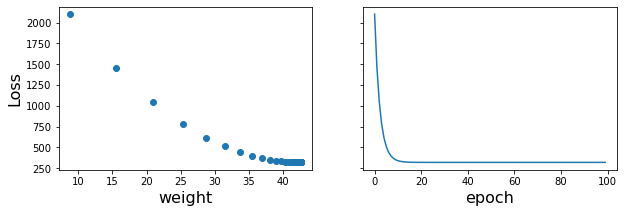

In [8]:
# set epoches and learning rate
epochs = 100
lrate = 0.1

# store results
(weights, losses) = GD_onefeature(x,y,epochs,lrate)

# plot loss and weight values
fig, ax = plt.subplots(1,2, figsize=(10,3), sharey=True)

# Loss vs weights plot
ax[0].scatter(weights, losses)
ax[0].set_xlabel("weight", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)

# Loss vs epoch plot
ax[1].plot(range(epochs), losses)
ax[1].set_xlabel("epoch", fontsize=16)


plt.show()

<a id='St2'></a>
<div class=" alert alert-warning">
   <h3><b>STUDENT TASK 2.2.</b> GRADIENT DESCENT - LEARNING RATE. </h3>

Your task is to try out different learning rates for the GD implementation provided in the function `GD_onefeature()`. For each value of the learning rates in the list `lrates` run the function `GD_onefeature()` that returns the sequence of weights $w^{(1)},w^{(2)},\ldots$ and corresponding loss values $f\big(w^{(1)}\big),f\big(w^{(2)}\big)$. Store these sequences in the lists `weights_list` and `loss_list`, respectively. For each learning rate, depict the trajectory of GD given by the points $\big(w^{(k)},f\big(w^{(k)}\big)\big)$, index by the GD iteration number $k$, in a plot with horizontal axis representing the weight values and vertical axis representing the loss function values (see plot below for reference). <br>
</div>

 <img src="../../../coursedata/SGD/STlrate.png" width=460/>

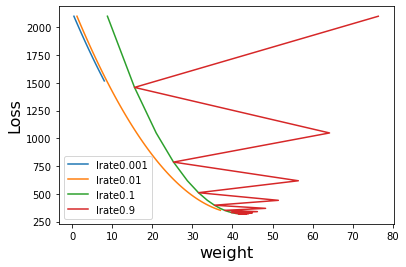

In [9]:
epochs = 100
lrates = [0.001, 0.01, 0.1, 0.9]

fig = plt.figure(figsize=(6,4))
weights_list = []
loss_list = []

# YOUR CODE HERE

for lrate in lrates:
    # use GD_onefeature function (GD_onefeature(x, y, epochs, lrate))
    # to get weights & loss values for a certain lrate
    # append these values to weights_list & loss_list
    weights, losses = GD_onefeature(x, y, epochs, lrate)
    weights_list.append(weights)
    loss_list.append(losses)

# plot results
for i,lrate in enumerate(lrates[:4]):
    plt.plot(weights_list[i], loss_list[i], label=f"lrate{lrate}")
    plt.legend()

plt.xlabel("weight", fontsize=16)
plt.ylabel("Loss", fontsize=16)  
plt.show()

In [10]:
# Sanity checks
assert len(weights_list)==len(lrates), "Length of list `weights_list` should be equal to length of `lrates`"
assert len(weights_list[0])==epochs, "Length of list `weights_list[0]` should be equal to epoch number"
assert len(loss_list)==len(lrates), "Length of list `loss_list` should be equal to length of `lrates`"
assert len(loss_list[0])==epochs, "Length of list `loss_list[0]` should be equal to epoch number"

In [11]:
# hidden tests


In [12]:
# hidden test


Based on the graph, which learning rate values do you think are suboptimal? What will happen if learning rate `lrate= 1` is used?

Below we plot data points and linear predictors with weights computed at 1st, 50th and 100th epochs for each learning rate.

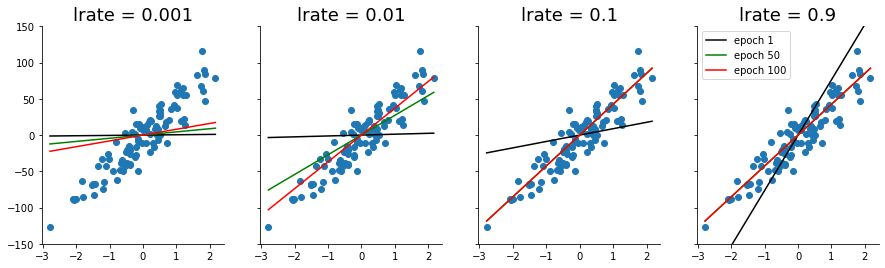

In [13]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(15,4))

for i in range(len(lrates)):
        x_grid = np.linspace(x.min(),x.max(),100)     # x-axis values for plotting
        y_pred_1 = weights_list[i][0]*x_grid          # get weight computed at epoch 1 and compute predictions
        y_pred_50 = weights_list[i][49]*x_grid        # epoch 50
        y_pred_100 = weights_list[i][99]*x_grid       # epoch 100
        
        ax[i].scatter(x,y) # plot data points
        ax[i].plot(x_grid, y_pred_1, label="epoch 1", c='k')      # plot predictor with weight at epoch 1
        ax[i].plot(x_grid, y_pred_50, label="epoch 50", c='g')    # plot predictor with weight at epoch 50
        ax[i].plot(x_grid, y_pred_100, label="epoch 100", c='r')  # plot predictor with weight at epoch 100
        
        # remove top and right subplot's frames 
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        # set subplot's title
        ax[i].set_title("lrate = "+str(lrates[i]), fontsize=18)

ax[3].legend()
plt.ylim(-150,150)      
plt.show()       

<a id='St3'></a>
<div class=" alert alert-success">
    <h3><b>STUDENT TASK 2.3. (OPTIONAL, not graded) . </b> GRADIENT DESCENT. </h3> 
    
This is an <strong>optional (not graded)</strong> task where you will try vectorized implementation of GD for data points with many features. You will need the knowledge of matrix multiplication for completing the task.
    
    
Your task is to write Gradient Descent implementation for a dataset of size $m$, where $i$th datapoint is characterized by $n$ features stored in feature vector $\mathbf{x}^{(i)}$.

The feature vectors of each datapoint are stored in matrix $X$ of shape $(m,n)$. The true labels of datapoints are stored in label vector $\mathbf{y}$ of shape (m,1). 

You need to implement similar steps as previously, but in this case the loss function is:

\begin{align} 
f\big( \mathbf{w}\big)= (1/m) \sum_{i=1}^{m}\big(y^{(i)} - \mathbf{w}^{T} \mathbf{x}^{(i)} \big)^2
\end{align}
    
    
and the gradient:
    
\begin{align} 
\nabla f\big( \mathbf{w}^{(k)} \big)= - (2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big) \big)
\end{align}
    
where $\mathbf{x}^{(i)}$ and  $\mathbf{w}$ are arrays of shape $(n,1)$ and $n$ is a number of features.
</div>



<details>
    <summary>
        <span class="summary-title">Hints</span>
    </summary>
    <div class="summary-content">

To implement the vectorized GD, you can use following formulas:

$
\begin{align}
  \hat{y} &= X \times w \\
  \\
  MSE &= \frac{1}{m}  \Sigma_{i=1}^m{(y - \hat{y})^2} \\
  \\
  \nabla f\big( \mathbf{w} \big) &= - \frac{2}{m} X^T \times (y - \hat{y}) \\
  \\
  w &= w - \alpha \nabla f\big( \mathbf{w} \big)
\end{align}
$

where: <br>
 $\times$ represents the matrix multiplication (`@` operator in numpy) and $T$ is a transpose operator.
     </div>    
</details>    

In [42]:
def gradient_step(X, y, weight, lrate):
    
    '''
    Function for performing gradient step with MSE loss function.
      
     The inputs to the function are:
    - numpy array (matrix) with feature values X of shape (m,n)
    - numpy array with labels y of shape (m,1)
    - numpy array `weight` of shape (n,1), which is the weight used for computing prediction
    - scalar value `lrate`, which is a coefficient alpha used during weight update

    The function will return a new weight guess (updated weight value) and current MSE value.   
    
    '''
# YOUR CODE HERE
    
    # performing Gradient Step:

    # 1. Compute predictions, given the feature matrix X of shape (m,n) and weight vector w of shape (n,1).
    #    Predictions should be stored in an array `y_hat` of shape (m,1).
    y_hat = np.array([x @ weight for x in X])
    
    
    # 2. compute MSE loss
    m = X.shape[0]
    MSE = np.mean(np.square(y-y_hat))
    
    # 3. compute average gradient of loss function
    gradient = - 2/m * np.transpose(X)@(y-y_hat)
    
    # 4. update the weights
    weight = weight - lrate * gradient
    
    return weight, MSE 


In [43]:
# test your solution 
from round02 import test_gradient_step

test_gradient_step(gradient_step)

Now, let's use the completed `gradient_step()` function and define the `GD()` function that will repeat the gradient step for fixed amounts of times (epochs).

In [44]:
def GD(X,y,epochs,lrate):  
    '''
    Function for performing gradient descent for linear predictor and MSE as loss function.
    The helper function `gradient_step` performs gradient step for dataset of size `m`, 
    where each datapoint has `n` features. 
    
    '''
    
    # initialize the weight vector randomly
    np.random.seed(42)
    weight = np.random.rand(X.shape[1],1)    
    # create a list to store the loss values 
    weights = []
    losses = []
     
    for i in range(epochs):
        # run the gradient step for the whole dataset
        weight, MSE = gradient_step(X, y, weight, lrate)
        # store the MSE loss of each batch of each epoch
        weights.append(weight)
        losses.append(MSE)
                       
    return weights, losses

In [45]:
# generate a dataset for a regression problem
# in this case we will set number of features to four

X2, y2 = make_regression(n_samples=100, n_features=4, noise=20, random_state=42) 
y2 = y2.reshape(-1,1)

X2 = preprocessing.scale(X2)

print("Shape of feature matrix X2 (n_samples, n_features): ", X2.shape)
print("Shape of label vector y2 (n_samples, 1): ", y2.shape)

Shape of feature matrix X2 (n_samples, n_features):  (100, 4)
Shape of label vector y2 (n_samples, 1):  (100, 1)


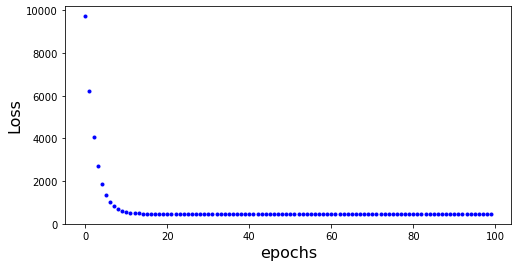

In [46]:
# set epoch and learning rate
epochs = 100
lrate = 0.1

# store results
(weights, losses) = GD(X2, y2, epochs, lrate)

# print the cost function
fig,ax = plt.subplots(figsize=(8,4))

ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)
ax.plot(range(epochs), losses, 'b.')

plt.show()

<a id='St4'></a>
<div class=" alert alert-warning">
    <h3><b>STUDENT TASK 2.4.</b> Compare your implementation with sklearn `LinearRegression` class. </h3>
    
We can compare the optimal weights learned by our simple algorithm and the optimal weight calculated by Sklearn's <a href=https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html>LinearRegression</a> class. This class does not use iterative gradient-based algorithms but rather calculate the optimal weight analytically <a href="https://www.youtube.com/watch?v=B-Ks01zR4HY">learn more here</a>.

Retrieve weight returned by `GD_onefeature()` function on the last epoch. Store it in variable `gd_weight`.
Note, if weight returned by `GD_onefeature()` is similar to the optimal weight returned by sklearn `LinearRegression()` class. 
</div>

In [47]:
# set epoch and learning rate
epochs = 100
lrate = 0.1

# create a linear regression model 
reg = LinearRegression(fit_intercept=False) 
# fit the linear regression model
reg.fit(x, y)
# print the optimal coefficients
print(f'Optimal weights calculated by the LinearRegression model: {reg.coef_.reshape(-1,)}')

# YOUR CODE HERE

# retrieve weight values returned by `GD_onefeature()` on the LAST epoch
weights, _ = GD_onefeature(x,y,epochs,lrate)
gd_weight = weights[-1]


print(f'{" "*9} Optimal weights calculated by the GD algorithm: {gd_weight.reshape(-1,)}')

Optimal weights calculated by the LinearRegression model: [42.59035782]
          Optimal weights calculated by the GD algorithm: [42.59035781]


In [48]:
# Sanity check
from numpy.testing import assert_almost_equal
assert_almost_equal(reg.coef_.reshape(-1,), gd_weight.reshape(-1,), err_msg="reg.coef_ and gd_weight should be equal! ")

In [49]:
# hidden test


With correct implementation of `gradient_step_onefeature()` you should see that optimal weight value returned by our algorithm and `LinearRegression` are close (equal to 7 decimal places). Thus, our simple gradient descent algorithm does not deviate too much from the `Sklearn` implementation of linear regression. 

<a id='St5'></a>
<div class=" alert alert-success">
     <h3><b>STUDENT TASK 2.5. (OPTIONAL, not graded). </b> STOPPING CRITERIA. </h3>
    
Your task is to modify <code>GD_onefeature()</code> or <code>GD()</code> code and introduce stopping criteria other than a fixed number of iterations (epochs). You will need to compare loss values returned on the last two epochs and stop GD when the loss will stop decreasing significantly (e.g. the loss decrease is less than 1e-6). In addition, introduce a maximum number of iterations GD can perform, in order to prevent GD from running for a long time. The function should return last weight(s), loss, and the number of iterations performed.
    
</div>

<details>
    <summary>
        <span class="summary-title">Hints</span>
    </summary>
 <div class="summary-content">
     <ul>
 <li> You can use for-loop to iterate epoch times (maximum number of iterations) and if loop to check if the stopping condition(s) is true.</li>
 <li> You can use `math.isclose()` function to compare 2 values to desired precision.</li>
     </ul>
  </div>    
</details>    

In [56]:
import math

def GD_stop(X, y, epochs, lrate):  
    
    '''
    
    Function for performing gradient descent for linear predictor and MSE as loss function.
    The helper function `gradient_step_onefeature` performs gradient step for dataset of size `m`, 
    where each datapoint has one feature. 
    
    '''
    # initialize weight vector randomly
    np.random.seed(42)
    weight = np.random.rand()   
    weights, loss = [], []
    
# YOUR CODE HERE
    for iterations in range(epochs):
        weight, mse = gradient_step_onefeature(X, y, weight, lrate)
        weights.append(weight)
        loss.append(mse)
        if math.isclose(mse, 1e-6):
            return weights, loss, iterations

    return weights, loss, iterations

In [57]:
# set learning rate
lrate = 0.1
epochs = 100

# store the results
(weights, losses, iterations) = GD_stop(x, y, epochs, lrate)

print(f'Number of epochs: {iterations}\nLoss: {losses[-1]}\nWeights:{weights[-1].reshape((-1, ))}')

Number of epochs: 99
Loss: 318.79310879490555
Weights:[42.59035781]


Note, if algorithm stopped earlier than epochs set. Try to change tolerance parameters in `math.isclose()` and see if there is a difference.

<div class="wrap-up">
    <div class="wrap-up-title">Wrap up - Gradient Descent</div><br>
    <div class="wrap-up-content">
        <ul>
          <li>Gradient Descent (GD) is one of the most popular optimization methods used in the training of artificial neural networks.</li>
          <li>GD is an iterative algorithm used to find optimal parameters (weights) of the model (ANN).</li>
          <li>GD makes small steps in the opposite direction of the gradient, which is also the direction of the steepest descent.</li>
          <li>Learning rate of GD will define how big are steps made in order to reach the minimum of the loss function.</li>
          <li>If the learning rate is too small, it will take a long time for GD to learn optimal weights. If the learning rate is too high, GD parameters update will overshoot the minimum of the loss function and loss values will fluctuate around the minimum, or in the worst case, GD may diverge.</li>
        </ul>
    </div>
</div>

# Stochastic Gradient Descent 

Despite its conceptual simplicity, GD might not be practical in ML applications involving massive amounts of data. Consider image classification where state-of-the-art deep learning methods are trained on billions of images. The challenge in using GD for such big data applications is the computational complexity of computing the gradient $\nabla f\big( \mathbf{w}^{(k)} \big)$ of the loss function at the current estimate $\mathbf{w}^{(k)}$. 

Let us have a closer look at the computation of the gradient for the special case of linear predictor maps $h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$. In this case, we can find a closed-form expression for the gradient: 

\begin{align} 
\nabla f\big( \mathbf{w}^{(k)} \big)= - (2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big) \big). \end{align}

The difficulty is that the summation involves all $m$ data points that form the training set. Thus, we might need to sum over billions of data points. Moreover, the data points might be stored decentralized all over the internet (in the "cloud"). A single iteration of GD might then simply take too long.

In order to avoid the computational burden of computing the gradient, **stochastic GD (SGD)** approximates the gradient by using only a small subset (**batch**) of training data points. SGD is obtained from GD by replacing the exact gradient step with a noisy gradient update: 

$$\mbox{(Noisy Gradient Step)} \quad \underbrace{\mathbf{w}^{(k+1)}}_{\mbox{new guess}} = \underbrace{\mathbf{w}^{(k)}}_{\mbox{current guess}} - \underbrace{\alpha^{(k)}}_{\mbox{step size}}\mathbf{g}^{(k)} \mbox{ with } \mathbf{g}^{(k)} \approx \nabla f\big(\mathbf{w}^{(k)}\big).$$ 

Note that we now use a varying step-size $\alpha^{(k)}$ that changes along with the iterations. This is necessary in order to avoid accumulation of the gradient noise during the SGD updates. SGD methods typically decrease the learning rate $\alpha^{(k)}$ as the iterations proceed. 

The most basic variant of SGD uses a single randomly chosen data point for computing the gradient estimate $\mathbf{g}^{(k)}$. For the special case of linear predictor maps, we obtain 
$$ \mathbf{g}^{(k)}   = -2 \mathbf{x}^{(I)} \big(y^{(I)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(I)} \big) \big).$$

Note that the index $I$ of the data point is chosen randomly and independently for each new iteration $k$. Comparing this gradient estimate with the above formula for the exact gradient, we see that the SGD iteration does not require any summation over the training set. For large training sets, this might yield a significant reduction in computational requirements for SGD compared to GD. 

Plain SGD and GD can be interpreted as special cases of **mini-batch SGD**. Mini-batch SGD does not use a single randomly chosen data point to compute the gradient estimate but rather uses several randomly chosen data points that form a batch $\mathcal{S} = \big\{ \big(\mathbf{x}^{(i_{1})},y^{(i_{1})} \big),\ldots,\big(\mathbf{x}^{(i_{S})},y^{(i_{S})} \big) \big\}$ of size $s$. For linear predictor maps, the gradient estimate is computed using the batch via 
$$ \mathbf{g}^{(k)}   = -(2/s) \sum_{\big(\mathbf{x},y\big) \in \mathcal{S}} \mathbf{x} \big(y - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x} \big) \big).$$

Each iteration of mini-batch SGD uses a different batch of $s$ different data points. A sequence of iterations that uses each data point in one of the batches is referred to as one **epoch** (i.e. batches are disjoint). For example, if the training data set consists of $50$ data points and we use a batch size of $s=10$, then one epoch requires $50/10 = 5$ iterations of mini-batch SGD.  


<img src="../../../coursedata/SGD/batch.png" alt="Drawing" style="width: 1000px;"/>

Important special cases of mini-batch SGD are obtained for certain choices of the **batch size**: 

- GD (also called batch GD or vanilla GD, batch size = size of dataset)
- Mini-batch GD (1 < batch size < whole dataset)
- SGD (batch size = 1)

Note that the computational complexity of one iteration of mini-batch GD depends only on the batch size. Thus, 
for a fixed batch size (e.g. $s=128$) the complexity (runtime) of a single iteration becomes independent of the total number of training data points. 

<a id='St6'></a>
<div class=" alert alert-warning">
    <h3><b>STUDENT TASK 2.6.</b> STOCHASTIC GRADIENT DESCENT.</h3> 
    
In this task, we modify our GD algorithm (function `GD_onefeature`) by providing and training the dataset in batches. You will need to complete <code>minibatchGD()</code> function, according to the instructions given below. 
    
</div>

Before implementing the SGD algorithm, we need to write a helper function `batch()` that divides the dataset into small batches. We will provide the feature vector or matrix `X` and label vector `y` as an input to the function. We also need to define the parameter `batch_size` which is the number of data points used for a single batch. The function `batch()` is a [Python generator function](https://docs.python.org/3/howto/functional.html#generators), meaning that the function can be used in for-loops and will return batches sequentially, one-by-one. Before splitting the dataset into batches, we will randomly shuffle the data. This ensures that every time we call `batch()` we obtain a batch having similar statistical properties. Loosely speaking, shuffling the dataset before creating the batches makes the individual data points independent and identically distributed ("i.i.d."). 

In [58]:
def batch(X,y,batch_size):
    
    '''
    Function for creating mini-batches of the dataset.
    The `yield` statement suspends the function’s execution and sends 
    a value back to the caller, but retains enough state to enable 
    function to resume where it is left off.  
    
    '''
    
    # shuffle data points 
    # the permutation will randomly re-arrange the order of the numbers
    # which will be used as indices to create X and y with data points in different order
    np.random.seed(42) # for reproducibility, should NOT be used in real training
    p = np.random.permutation(len(y))
    X_perm = X[p] 
    y_perm = y[p]
    
    # generate batches
    for i in range(0, X.shape[0], batch_size):
        yield (X_perm[i:i + batch_size], y_perm[i:i + batch_size])

<div class="info">
    <div  class="info-title"><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</div><br>
    <div class="wrap-up-content">
        You can test Python generator by using <code>next()</code> function:
    </div>
    
```python
>>> gen =  Generator(args)
>>> next(gen)
```
    
    or for-loop:
    
```python   
>>> for element in Generator(args):
    print(element)    
```

</div>

In [59]:
def minibatchGD(X, y, batch_size, epochs, lrate):  
    
    # initialize the weight randomly
    np.random.seed(42)
    weight = np.random.rand()  
    # create a list to store the loss values 
    losses = []
    weights = []
     
    for i in range(epochs):
# YOUR CODE HERE
        # Use another for-loop to iterate batch() generator and access batches one-by-one
        # Feed  current batch to `gradient_step_onefeature()` and get weight and loss values
        # Store current weight and loss values in corresponding lists
        for element in batch(X,y,batch_size):
            x, y = element[0], element[1]
            weight, loss = gradient_step_onefeature(x,y,weight,lrate)
            weights.append(weight)
            losses.append(loss)
      
       # one epoch is finished when the algorithm goes through ALL batches
    return weights, losses

<details>
    <summary>
        <span class="summary-title">Hints</span>
    </summary>
 <div class="summary-content">
     <a href="https://www.geeksforgeeks.org/generators-in-python/">Here</a> you can find an example of using Python generator with for-loop. Use the same approach to iterate batch() generator.
  </div>    
</details>    

In [60]:
# Sanity checks
# len(weights) and len(loss) should be:
# (number of samples/batch_size)*epochs - 100/50*2=4
weights, loss = minibatchGD(x, y, 50, 2, 0.1)

assert len(weights)==4, "weights length is not correct!"
assert len(loss)==4, "loss length is not correct!"

/opt/software/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/software/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
# hidden test


In [62]:
# hidden test


<a id='St7'></a>
<div class=" alert alert-warning">
    <h3><b>STUDENT TASK 1.7. </b> SGD - BATCH SIZE.</h3>
    
Try `minibatchGD()` function with different values of `batch_size` parameter and plot results.
    
Note - use feature vector **x** and label vector **y** as input data of  `minibatchGD()` function. 
</div>

Let's test our SGD implementation and run the algorithm for:

- batch sizes = 1 (one data point) **(SGD)**
- batch sizes = 10 **(mini-batch GD)**
- batch sizes = 100 (entire dataset) **(Batch GD)**

<details>
    <summary>
        <span class="summary-title">Hints</span>
     </summary>
     <div class="summary-content">
You can use for-loop to iterate list `batch_sizes` and pass these values to `minibatchGD()` function. 
    </div>
</details>    

In [ ]:
# set epoches and learning rate
epochs = 100
lrate = 0.02


batch_sizes = [1, 10, 100]
# list for storing weights and loss for each batch size (length of both lists=3)
# we will use these lists for plotting
weights_batches = []
loss_batches = []

# YOUR CODE HERE


# iterate `batch_sizes` list
for batch_size in batch_sizes:
#     compute weights & losses for a given batch size value
#     append weights & losses to lists weights_batches & loss_batches
    weights, loss = minibatchGD(x, y, batch_size, epochs, lrate)
    weights_batches.append(weights)
    loss_batches.append(loss_batches)
    


for batch_size, weights, loss in zip(batch_sizes, weights_batches,loss_batches):
    plt.plot(weights, loss, label="batch size"+str(batch_size))
    plt.legend()

plt.xlabel("weight", fontsize=16)
plt.ylabel("Loss", fontsize=16)  
plt.show()

In [ ]:
# Sanity checks

assert len(weights_batches)==len(batch_sizes), "weights_batches length is not correct!"
assert len(loss_batches)==len(batch_sizes), "loss_batches length is not correct!"
# below length computed as (number of samples/batch_size)*epochs
assert len(loss_batches[0])==10000, "loss_batches[0] length should be (100/1)*100=10000!"
assert len(loss_batches[1])==1000, "loss_batches[1] length should be (100/10)*100=1000!"
assert len(loss_batches[2])==100, "loss_batches[2] length should be (100/100)*100=100!"



In [ ]:
# hidden test


Note that the deviations are larger for smaller batch sizes. This makes sense, as the gradient estimates are more accurate when we use more data points in a batch. 

Let's use the loss values for each batch size stored in the list `loss_batches` for plotting and will print out learned weights stored in `weights_batches` list.

In [ ]:
# history of the MSE loss inccured during learning
batch_size1_loss   = loss_batches[0]
batch_size10_loss  = loss_batches[1]
batch_size100_loss = loss_batches[2]

# let's check that the length of list `loss` is equal to
# x.shape[0]/batch_size*epochs

print(f"Total number of iterations = (sample size/batch size)*epochs")
print(f"\nEpochs: {epochs}")
print(f"Sample size: {x.shape[0]}")
print(f"Batch sizes: 1, 10, 100")
print(f"Iterations per epoch: {x.shape[0]/1.0:.0f}, {x.shape[0]/10.0:.0f}, {x.shape[0]/100.0:.0f}")
print(f"Total number of iterations: {len(batch_size1_loss)}, {len(batch_size10_loss)}, {len(batch_size100_loss)}")

# display weights learnt during the SGD
print(f"\nWeights:\n\nSGD with batch size = 1 results in weight w = {weights_batches[0][-1]:.2f}\
                 \nSGD with batch size = 10 results in weight w = {weights_batches[1][-1]:.2f}\
                 \nSGD with batch size = 100 results in weight w = {weights_batches[2][-1]:.2f}")

The results of SGD with different batch sizes should be pretty close. Let's compare our SGD implementation with sklearn [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) class implementation. In `SGDRegressor` implementation, the gradient of the loss is estimated each sample at a time (batch size=1 in other words) and the model is updated along the way with a decreasing learning rate.

In [ ]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(fit_intercept = False, max_iter=100, tol=1e-3)
reg.fit(x,y.reshape(-1,))

reg.coef_[0]

Thus, our simple SGD algorithm does not deviate too much from the `sklearn` implementation. \
Let's plot the loss values for the first 100 iterations incurred during the training.

In [ ]:
# create the figure and axes objects
# there will be 3 subplots in one row, the y-axis is shared between subplots
fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,5))

# create lists of loss values and batch sizes for further iteration in for-loop
batch_loss_list = [batch_size1_loss, batch_size10_loss, batch_size100_loss]
batch_size      = [1,10,100] 

for ax, batch_loss, size in zip(axes, batch_loss_list, batch_size):
    # plot only first 100 values
    ax.plot(np.arange(len(batch_loss[:100])), batch_loss[:100])
    # remove top and right subplot's frames 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set subplot's title
    ax.set_title("batch size = "+str(size), fontsize=18)

# set x- and y-axis labels
axes[0].set_xlabel('batch #', fontsize=18)
axes[0].set_ylabel('Loss', fontsize=18)

# display figure
plt.ylim(0,10000)
plt.show()

The above figure indicates that when using SGD with a small batch size, the loss is not decreasing monotonically but somewhat randomly fluctuating around a long-term decreasing trend. This happens because the weight updates use "noisy" estimates of the gradient. The noisy estimate is calculated by an averaging process using the data points in the mini-batch. The smaller the mini-batch size, the fewer data points we use for computing the average. Thus, the gradient noise becomes stronger with smaller batch size. 

**Note!** In our exercises we used a constant learning rate. In order to avoid the accumulation of the gradient noise while running SGD updates, the learning rate needs to be gradually decreased, e.g. by using diminishing learning rate, thus resulting in a smoother learning curve.

Below are the animations illustrating the training process with SGD where the batch size is all data points (upper panel) and where the batch size is 10 data points (lower panel, the current batch marked with red color). In line with the loss plots we created above, mini-batch SGD is noisier than batch GD. Although it seems that using plain batch GD is a faster way to reach the minimum of the loss function, in practice when working with large datasets and thousands of parameters (weights) in neural networks, this approach will be slower and more computationally expensive than mini-batch SGD.

**Illustration of SGD iterations for batch size = 100 (batch covers entire dataset)** 

<img src="../../../coursedata/SGD/minibatchGD1.gif" width="750" align="center">

**Illustration of SGD iterations for batch size = 10 datapoints**

<img src="../../../coursedata/SGD/minibatchGD2.gif" width="750" align="center">

During each iteration of SGD, 10 data points are randomly selected to constitute a batch. This batch is used to compute the gradient estimate. The data points in the batch are shown in red. Note that during each iteration, a different set of 10 data points is chosen for the batch.  

<div class="wrap-up">
    <div class="wrap-up-title">Wrap up - Stochastic Gradient Descent</div><br>
    <div class="wrap-up-content">
        <ul>
          <li>Vanilla or batch GD computes the gradient of the loss function w.r.t. to the parameters (weights) for the entire training dataset. Therefore, to perform just one update, the gradient of the whole dataset needs to be computed, which makes batch GD very slow.</li>
          <li>SGD, in contrast, computes the gradient of the loss function and performs updates for each data point.</li>
          <li>SGD performs faster parameter updates, but suffers from high variance, especially with a constant learning rate.</li>
          <li>Mini-batch GD computes the gradient of the loss function for every batch of the dataset, thus combines the benefits of both, batch GD and SGD. It is faster than batch GD but prone to less variation in parameters up-dates than SGD.</li>
          </ul>
          <br>
        Note, that in deep learning literature mini-batch GD sometimes is also called SGD.
    </div>
</div>

# Variants of Gradient-Based Optimization Algorithms

Besides plain GD or mini-batch SGD, many deep learning methods use somewhat more advanced variants of gradient-based algorithms or optimizers ([list of optimizers available in deep learning Python library Keras](https://keras.io/api/optimizers/)). Some of the most known are SGD with momentum, RMSprop, and Adam. 

Much like GD and SGD, these algorithms use gradients of the loss function $f(\mathbf{w})$ to find weights $\mathbf{w}$ such that the predictor $h^{(\mathbf{w})}$ achieves (nearly) minimum loss. These variants differ in how they use (or "interpret") the gradient information to find the fastest route towards the minimum. In some cases, these variants can find good weight vectors significantly faster (using fewer iterations) compared to mini-batch SGD. 

## Gradient Descent with momentum

One simple improvement of gradient descent is adding a "momentum" term to the weight update equation. GD manages poorly when the loss surface is much steeper in one dimension than in the other, e.g. in ravines of the loss function. You can see on the animation below loss "landscape": weights values are shown on x and y axes and loss values are shown on the z-axis. GD (black trace) bounces back and force in the narrow symmetric ravine, unable to converge to the minimum of the loss function.

The addition of the "momentum" helps to damp oscillations and accelerate in the relevant direction. The common analogy is the ball moving in a bowl and gaining speed and momentum in the downhill direction, rather than moving to the left or right on the sides of the bowl.\
GD with momentum is implemented by storing the information about past gradients in a vector ${v}_{t}=\beta*{v}_{t-1} + \alpha*\nabla f$.\
The weight is updated as follows:
${w}_{t}={w}_{t-1}-{v}_{t}$

Momentum will increase for dimensions where gradients will point in the same direction and will decrease for dimensions where gradients change direction (oscillates). You can see on the animation below, how GD with momentum (red trace) decreases "zigzagging" amplitude and moves faster in the direction of the minimum of the loss function. Note that it also overshoots the minimum, but "corrects" itself and moves back converging to the minimum. Setting $\beta$ to a lower value would decrease momentum and would prevent overshooting. 

<img src="../../../coursedata/SGD/GDMomentum2.gif" width="700" align="left">

Below you can see how GD with momentum (red trace) gained momentum after the first weights update, escaped the ravine, and "hopped" over "hill" (the area where loss values are higher). In this case, it may be not an optimal path to the minimum, but in the more complex landscapes momentum can help to escape the local minimum given big enough momentum.

<img src="../../../coursedata/SGD/GDMomentumRosenbrock2.gif" width="750" align="left">

Other variants of GD improve different aspects of the algorithm. Nesterov accelerated gradient is basically a modification of the GD with momentum. Adagrad and its extension Adadelta uses different learning rates for parameters, which is useful when dealing with sparse data. RMSprop and Adam are currently a popular choice of GD-based variants with an adaptive learning rate ([paper about GD variants](https://arxiv.org/pdf/1609.04747.pdf)). 

The animation below compares the "routes" taken by several optimizers to find a minimum of the [six-hump camel](https://www.sfu.ca/~ssurjano/camel6.html) function. As you can see different GD variants may take different paths, which can be controlled by hyperparameters tuning (such as learning rate and coefficients like $\beta$ in GD with momentum).

<img src="../../../coursedata/SGD/camel3D.gif" width="750" align="left">

# Conclusion 

We have discussed the basic idea of using gradients of loss functions to iteratively improve the parameter values (weights) in a predictor map. Gradient-based methods such as SGD and its variants turn out to be the perfect tool for training deep neural networks in several aspects. First, somewhat surprisingly, SGD quickly finds weights for an ANN such that it performs well on new data points which are different from the training data. Moreover, mini-batch SGD requires only to have enough working memory ("RAM") to store the current batch (subset) of training data points instead of the entire dataset (which might be billions of high-resolution images). 


## Quiz

<div class="alert alert-warning">
     <h3><b>Question 2.1.</h3>

What is the role of a loss function within machine learning methods?
         
Select one:

1. To reduce the memory requirements of a machine learning method.

2. To transform the data into a computer-friendly format.

3. To speed up the learning process of an ML method.

4. To measure the quality of a particular predictor map.
         
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE

answer_21  = 4

In [ ]:
# This cell is for tests
assert answer_21 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class="alert alert-warning">
     <h3><b>Question 2.2.</b></h3>
         
Consider the average loss, or training loss, incurred by a predictor map on a set of labeled data points (the training set). The predictor map involves some adjustable weights. Which of the following statements is correct?
Select one:

1. The training loss (average loss incurred on training data points) depends only on the labels.

2. The training loss does not depend on the weights of the predictor map.

3. The training loss does not depend on the features of the data points in the training set.

4. The training loss depends on the features, labels of training data points as well as on weights of the predictor map.
    
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE

answer_22  = 4

In [ ]:
# This cell is for tests
assert answer_22 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class="alert alert-warning">
     <h3><b>Question 2.3.</h3>

Which one of the following completions of the sentence below is correct? Gradient descent is a ...

1. method to visualize data points.

2. iterative algorithm for finding a good choice for the weights (parameters) of a predictor map.

3. method to avoid overfitting.

4. method to divide the data into batches.
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
raise NotImplementedError()

answer_23  = 2

In [ ]:
# This cell is for tests
assert answer_23 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class="alert alert-warning">
     <h3><b>Question 2.4.</b></h3>

Consider a single GD step (update) $\mathbf{w}^{(k+1)}=\mathbf{w}^{(k)}−\alpha \nabla f(\mathbf{w}^{(k)})$ using the training loss $f(\mathbf{w})$ incurred by an ANN with parameters $\mathbf{w}$ on $m$ labeled training data points $(\mathbf{x}^{(1)},{y}^{(1)}),…,(\mathbf{x}^{(m)},{y}^{(m)})$. The function $f(\mathbf{w})$ is known to be differentiable and convex. The GD update includes an adjustable (tunable) parameter $\alpha>0$ which is referred to as step size or learning rate. Which of the following statements is correct?

Select one:

1. The GD iterates $\mathbf{w}^{(0)},\mathbf{w}^{(1)},\mathbf{w}^{(2)},…$ converge always, no matter what our choice is for $\alpha$.

2. The GD iterates can only converge if the feature vectors $\mathbf{x}^{(1)},…,\mathbf{x}^{(m)}$ have a norm smaller than one. 

3. If we choose too **small** learning rate $\alpha$, GD iterates will converge anyway (assuming infinite time and computational resources).

4. If we choose too **large** learning rate $\alpha$, GD iterates will converge anyway (assuming infinite time and computational resources).   
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE

answer_24  = 3

In [ ]:
# This cell is for tests
assert answer_24 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class="alert alert-warning">
     <h3><b>Question 2.5.</h3>

Pick the correct completion for the following sentence. 

In contrast to plain gradient descent (GD), stochastic gradient descent (SGD) ...


1. is guaranteed to strictly decrease the training error after each iteration.

2. always learns ANN parameters resulting in smaller training errors than the parameters learnt by GD.

3. can only be used for ANNs with more than 100 layers.  

4. typically requires less computation (time).   

</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
answer_25  = 4

In [ ]:
# This cell is for tests
assert answer_25 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class="alert alert-warning">
     <h3><b>Question 2.6.</h3>

Which one of the following statements is correct?

1. The batch size in SGD has no influence on the prediction accuracy obtained with the learnt ANN parameters. 

2. A single iteration of gradient descent updates the parameter vector into the opposite direction of the gradient of the loss function.

3. A single iteration of gradient descent updates the parameter vector into the direction of the gradient of the loss function.

4. In the context of SGD, one epoch refers to one single update of the ANN parameters based on a noisy gradient estimate computed over a batch.   
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
answer_26  = 3

In [ ]:
# This cell is for tests
assert answer_26 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class="alert alert-warning">
     <h3><b>Question 2.7.</h3>
    
Consider a dataset consisting of 4800 data points $({x}^{(1)},{y}^{(1)}),…,({x}^{(4800)},{y}^{(4800)})$.
If we run mini-batch SGD with a batch size of 64 and for 100 epochs, what is the total number of iterations used in SGD? 
         
Select one option:

1. 30

2. 160000

3. 15

4. 7500
    
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
answer_27  = 4

In [ ]:
# This cell is for tests
assert answer_27 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')
